In [ ]:
! pip3 install evaluate
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Colab: /content/drive/Othercomputers/macbook_pro/fact-checking


In [ ]:
import logging
import torch

from src.classification_training import ClassificationTraining
from src.common import read_data, QTDataset, get_device
from src.models.bart_large_mnli import BartLargeMnliTokenizer, BartLargeMnliClassifier
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from tqdm.auto import tqdm
from torch import nn

CATEGORIES = ["statistical", "temporal", "interval", "comparison"]

logging.basicConfig(level=logging.ERROR)

device = get_device()

label_endocer = LabelEncoder()
label_endocer.fit(CATEGORIES)
label_endocer.classes_

CUDA: 1, use NVIDIA A100-SXM4-40GB


array(['comparison', 'interval', 'statistical', 'temporal'], dtype='<U11')

In [ ]:
model = BartLargeMnliClassifier(labels_count=len(CATEGORIES)).to(device)
tokenizer = BartLargeMnliTokenizer()

In [ ]:
train_claims = read_data('raw_data/train_claims.json')
val_claims = read_data('raw_data/val_claims.json')
test_claims = read_data('raw_data/test_claims.json')

def build_dataset(claims: QTDataset) -> TensorDataset:
    # features
    features = [claim['claim'] for claim in claims]
    input_tokens = []
    attention_masks = []

    for feature in tqdm(features):
        input_token, attention_mask = tokenizer(feature)
        input_tokens.append(input_token)
        attention_masks.append(attention_mask)

    input_tokens = torch.cat(input_tokens)
    attention_masks = torch.cat(attention_masks)

    # labels
    labels = [claim['taxonomy_label'].strip() for claim in claims]
    encoded_labels = torch.tensor(label_endocer.transform(labels))

    return TensorDataset(input_tokens, attention_masks, encoded_labels)

train_dataset = build_dataset(train_claims)
val_dataset = build_dataset(val_claims)
test_dataset = build_dataset(test_claims)

  0%|          | 0/9935 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/3084 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/2495 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
training = ClassificationTraining(
    model_name="routing_model",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
    loss_function=nn.CrossEntropyLoss(),
    batch_size=16,
    device=device,
    random_state=0
)

training.start_new_training()

Starting new training from epoch 1



EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.537 | 78.56
   eval:  0.448 | 83.64
Saved best model: best_model_01


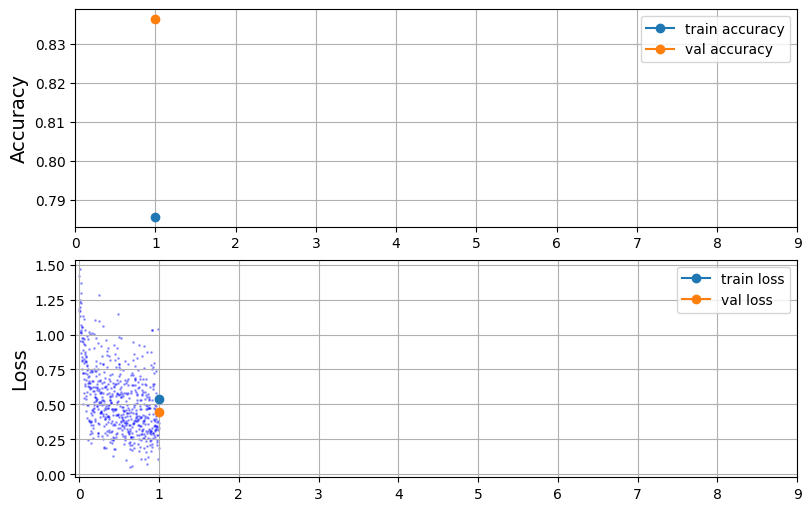


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.282 | 89.10
   eval:  0.374 | 85.63
Saved best model: best_model_02


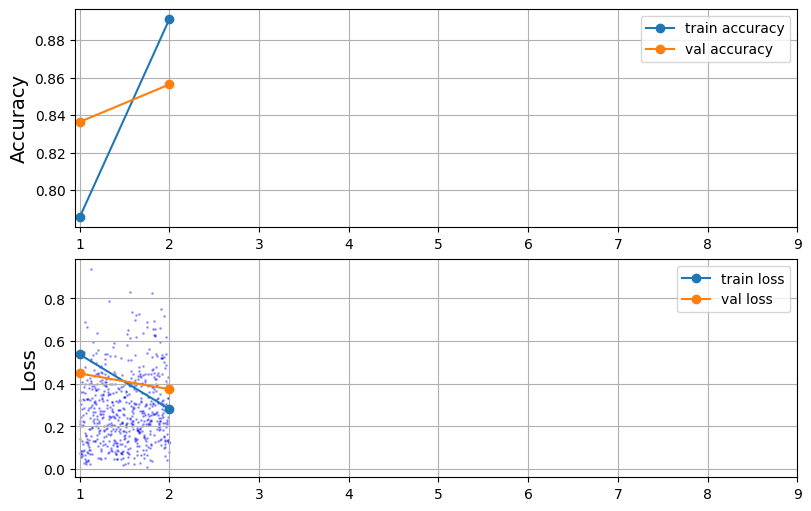


EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.147 | 94.56
   eval:  0.451 | 85.31
Early stopping counter: 1/3


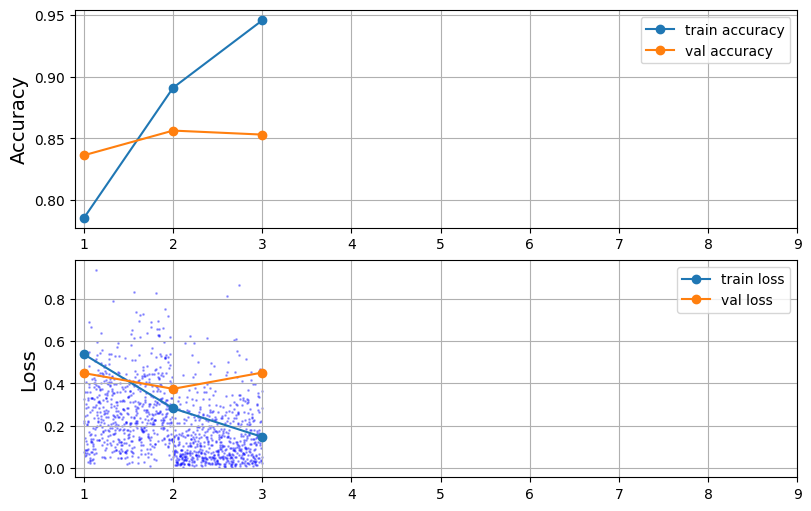

train:   0%|          | 0/621 [00:00<?, ?it/s]


EPOCH 4


val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.085 | 96.92
   eval:  0.483 | 86.47
Saved best model: best_model_04


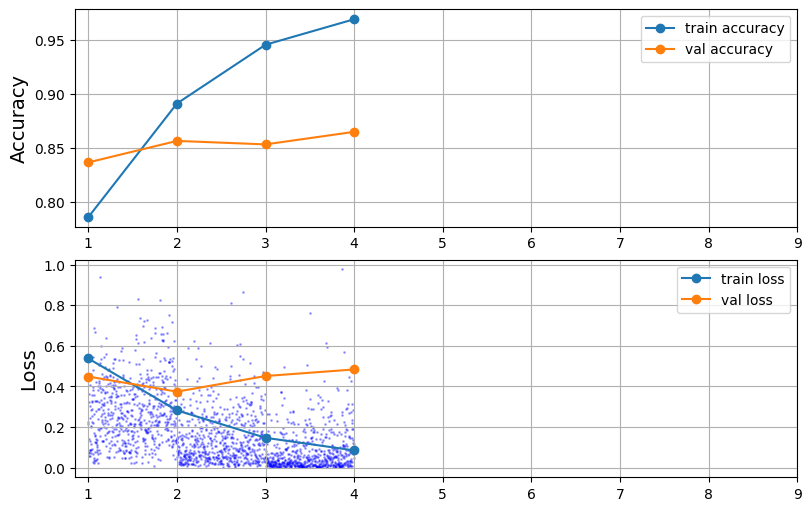


EPOCH 5


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.066 | 97.73
   eval:  0.579 | 85.64
Early stopping counter: 1/3


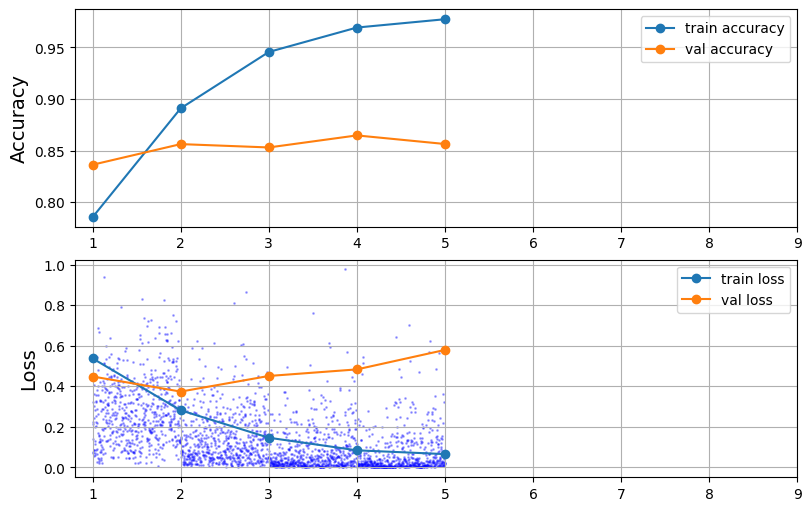


EPOCH 6


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.045 | 98.34
   eval:  0.633 | 85.54
Early stopping counter: 2/3


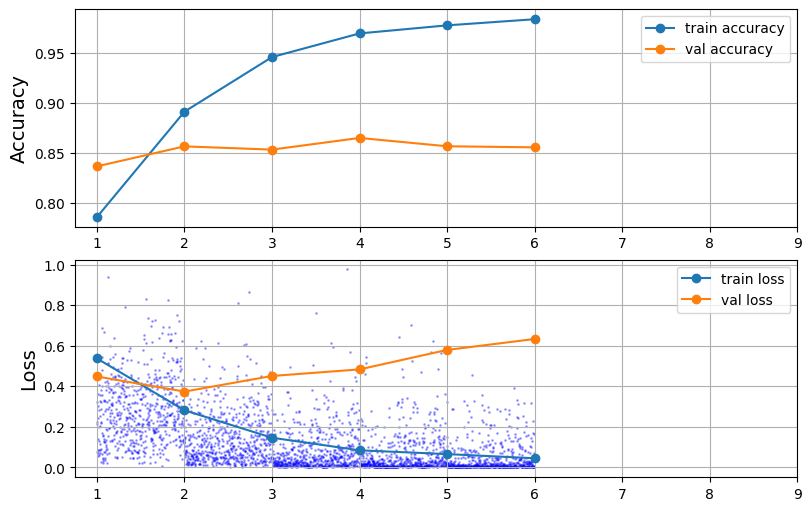


EPOCH 7


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.041 | 98.63
   eval:  0.583 | 86.67
Saved best model: best_model_07


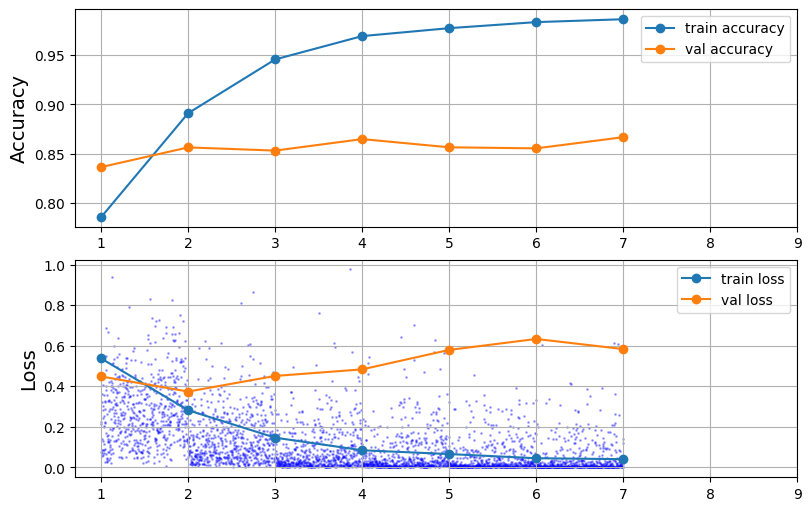


EPOCH 8


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.041 | 98.56
   eval:  0.634 | 85.45
Early stopping counter: 1/3


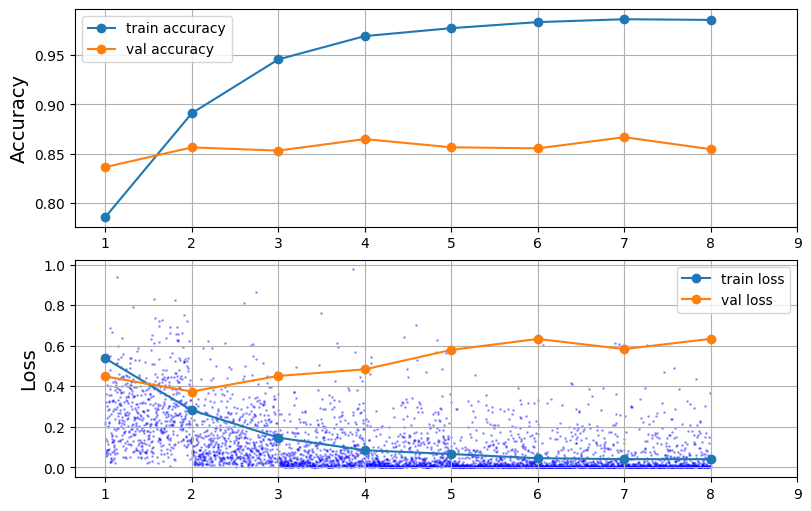


EPOCH 9


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.029 | 98.99
   eval:  0.817 | 84.97
Early stopping counter: 2/3


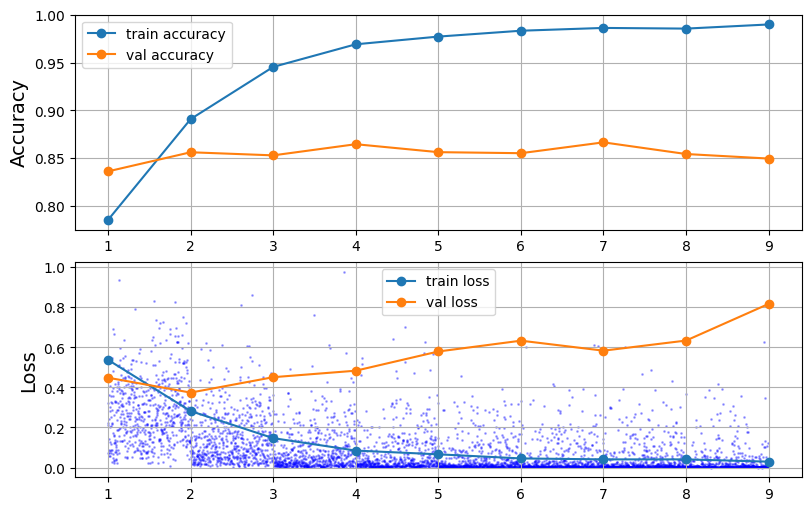


EPOCH 10


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.033 | 98.98
   eval:  0.762 | 85.38
Early stopping counter: 3/3


In [ ]:
training.train(epochs=20, patience=3)

In [ ]:
training.load_best_model()
test_predictions = training.predict(test_dataset)

Loading model: best_model_07


  0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
def accuracy(output: torch.Tensor, labels: torch.Tensor) -> float:
    if len(output.shape) == 2:
        output = torch.argmax(output, dim=1).flatten()

    labels_flat = labels.flatten()
    return torch.sum(output == labels_flat).item() / len(labels_flat)

test_accuracy = accuracy(test_dataset.tensors[2], torch.tensor(test_predictions))
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.8485
